In [12]:
from collections import defaultdict, Counter, OrderedDict
import numpy as np
from copy import copy, deepcopy
from itertools import groupby, permutations, product, combinations
import json
import matplotlib.pyplot as plt
import numpy as np
import math
import re
from time import sleep, time
from matplotlib import pyplot as plt
from matplotlib import colors
import sys
from collections import deque
import heapq

# DATA

In [2]:
f = open("inputs/aoc17.txt").read().splitlines()

In [3]:
m = 4

In [118]:
text_input = r"""2413432311323
3215453535623
3255245654254
3446585845452
4546657867536
1438598798454
4457876987766
3637877979653
4654967986887
4564679986453
1224686865563
2546548887735
4322674655533
"""

test = [list(l) for l in text_input.splitlines()]

In [202]:
def get_direction(from_node, to_node):
    dx = to_node[0]-from_node[0]
    dy = to_node[1]-from_node[1]
    return (dx,dy)

def last_directions(l):
    
    directions = []
    for i,c in enumerate(l[0:len(l)-1]):
    
        directions.append(get_direction(l[i+1],l[i]))
    return directions

class P:
    
    def __init__(self):
        self.results = []
        self.counter = 0
        self.directions = []
        self.size = 4
        self.steps_in_same_direction = 0
    
    def create_graph(self,text):
        
        temp = [list(line) for line in text]
        temp = np.array(temp).astype(int)
        self.heat_loss = temp
                          
        self.max_x = len(text)
        self.max_y = len(text[0])
        self.rows = self.max_y+1
        self.cols = self.max_x+1
        
        nodes = []
        for y,line in enumerate(text):
            for x,cost in enumerate(line):
                nodes.append({"coord":(x,y),"cost":cost})
        self.nodes=nodes
        graph = defaultdict(dict)
        
        for node in nodes:
            x, y = node['coord']
            cost = node['cost']
            neighbors = []

            # Check and add north neighbor
            if y > 0:
                neighbors.append((x, y - 1))
            # Check and add west neighbor
            if x > 0:
                neighbors.append((x - 1, y))
            # Check and add east neighbor
            if x < max(coord['coord'][0] for coord in nodes):
                neighbors.append((x + 1, y))
            # Check and add south neighbor
            if y < max(coord['coord'][1] for coord in nodes):
                neighbors.append((x, y + 1))

            # Add edges to the graph
            graph[node['coord']]={'neighbours':neighbors,'cost':int(cost)}

        self.graph = graph
        
    def last_three_same_as_first(self,list):
        res = False
        if len(list)>=3:
            res = all(i==list[0] for i in list)
        return res
        
    
    def compute_cost(self, current_min_node, neighbor):
        path_to_current_min_node = self.generate_path(current_min_node)
        directions = last_directions(path_to_current_min_node)
        
        new_direction = get_direction(from_node=current_min_node, to_node=neighbor)
        
        directions.insert(0,new_direction)
        
        last_three_same = self.last_three_same_as_first(directions[0:3])
        if last_three_same:
            cost = 1000000000000000000
        elif neighbor==path_to_current_min_node[-1]:
            cost = 1000000000000000000
        else:
            cost = self.graph[neighbor]['cost']

        return cost

    def opposite_direction(self, direction):
        return (-1*direction[0], -1*direction[1])
                    
                
    def dijkstra_algorithm(self,start_node=(0,0)):
        graph=self.graph
        unvisited_nodes = list(graph.keys())

        # We'll use this dict to save the cost of visiting each node and update it as we move along the graph   
        self.shortest_path = {}

        # We'll use this dict to save the shortest known path to a node found so far
        self.previous_nodes = {}

        # We'll use max_value to initialize the "infinity" value of the unvisited nodes   
        max_value = sys.maxsize
        for node in unvisited_nodes:
            self.shortest_path[node] = max_value
            
        # However, we initialize the starting node's value with 0   
        self.shortest_path[start_node] = 0

        # The algorithm executes until we visit all nodes
        while unvisited_nodes:
            
            # The code block below finds the node with the lowest score
            current_min_node = None
            for node in unvisited_nodes: # Iterate over the nodes
                if current_min_node == None:
                    current_min_node = node
                elif self.shortest_path[node] < self.shortest_path[current_min_node]:
                    current_min_node = node
            
            # print("------")
            # The code block below retrieves the current node's neighbors and updates their distances
            neighbors = graph[current_min_node]['neighbours']

            for neighbor in neighbors:   
                current_min_cost = self.shortest_path[current_min_node] 
                tentative_value = current_min_cost + self.compute_cost(current_min_node,neighbor)
                # print("current_min_node", current_min_node,"ngh:", neighbor,'tentativevalue',tentative_value)
                
                if tentative_value < self.shortest_path[neighbor]:
                    self.shortest_path[neighbor] = tentative_value
                    # We also update the best path to the current node
                    self.previous_nodes[neighbor]=current_min_node

            # After visiting its neighbors, we mark the node as "visited"
            unvisited_nodes.remove(current_min_node)
    
    def generate_path(self,node):
        nodes=[node]
        new_node = node
        while new_node != (0,0):
            new_node = self.previous_nodes[new_node]
            nodes.append(new_node)
        return nodes
    
    def plot_costs(self):
        plt.figure(figsize=(self.size,self.size))
        plt.ylim(self.max_y,0)
        a = np.ones((self.max_y, self.max_x))
        cmap = colors.ListedColormap(['Blue','red'])
        
        plt.pcolor(a,cmap=cmap,edgecolors='k', linewidths=1)
        
        for x in range(self.max_x):
            for y in range(self.max_y):
                s=self.heat_loss[y,x]
                plt.text(x+0.5,y+0.5,s,color='white', size=6)
    
    def plot_array(self,node):
        
        plt.figure(figsize=(self.size,self.size))
        plt.ylim(self.max_y,0)
        a = np.ones((self.max_y, self.max_x))
        
        shortest_path_coords = self.generate_path(node) 
        for i in shortest_path_coords:
            a[i[1],i[0]]=0
        
        cmap = colors.ListedColormap(['Blue','red'])
        
        plt.pcolor(a,cmap=cmap,edgecolors='k', linewidths=1)
        
        for x in range(self.max_x):
            for y in range(self.max_y):
                s=self.shortest_path[(x,y)]
                plt.text(x+0.5,y+0.5,s,color='white', size=6)
        
        plt.show()    
    
    def compute_loss(self, node):
        som = 0
        for c in p.generate_path(node)[:-1]:
            som = som + p.heat_loss[c[1],c[0]]
        return som

# Part 1

In [197]:
p = P()
p.create_graph(test)

In [198]:
p.dijkstra_algorithm()

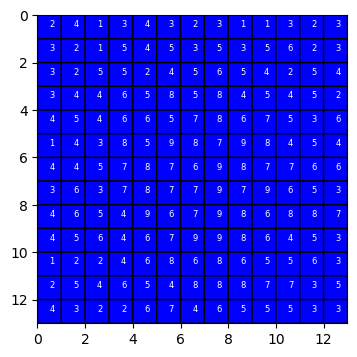

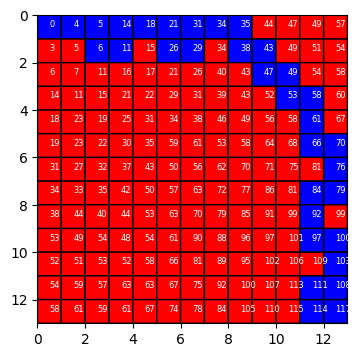

117

In [203]:
ec=(12,12)
p.plot_costs()
p.plot_array(ec)
p.compute_loss(ec)

# Part 2